In [21]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import random

# DQN commons

In [22]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [23]:
class QFunction(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [28]:
def dqn(agent, env, num_episodes, report=True, goal=200):        
    t_max = 5000
    total_rewards = []
    for episode in range(num_episodes):
        total_reward = 0
    
        state = env.reset()
        for t in range(t_max):
            action = agent.get_action(state)
            next_state, reward, done, _ = env.step(action)
    
            total_reward += reward
            
            agent.fit(state, action, reward, done, next_state)
            state = next_state
    
            if done:
                break

        if report:
            print(agent.report_overestimation())
            
        total_rewards.append(total_reward)
        if len(total_rewards) >= 100 and np.mean(total_rewards[-100:]) >= goal:
            print("Converged!")
            break
        print(f'episode: {episode}, total_reward: {total_reward}')
    return total_rewards + [total_rewards[-1]] * (num_episodes - len(total_rewards))

# Unified DQN with support of Soft Target, Hard Target, and DDQN strategies

In [41]:
class DQNx:
    def __init__(self, state_dim, action_dim, gamma=0.98, eps_start=1.0, eps_min=0.01, eps_decay_factor=0.98, lr=0.0001, batch_size=1024, memory_size=100000, tau=0.005, target_update=10, DDQN=False):
        self.q_function = QFunction(state_dim, 128, action_dim).to(DEVICE)
        self.target_q_function = QFunction(state_dim, 128, action_dim).to(DEVICE)
        self.target_q_function.load_state_dict(self.q_function.state_dict())
        self.target_q_function.eval()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.batch_size = batch_size
        self.epsilon = eps_start
        self.epsilon_decay = eps_decay_factor
        self.epsilon_min = eps_min
        self.memory_size = memory_size
        self.memory_counter = 0
        self.gamma = gamma
        self.optimizer = torch.optim.Adam(self.q_function.parameters(), lr=lr)
        self.tau = tau
        self.target_update = target_update
        self.update_count = 0
        self.DDQN = DDQN

        # Preallocate memory
        self.states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=DEVICE)
        self.actions_memory = torch.empty((memory_size, 1), dtype=torch.int64, device=DEVICE)
        self.rewards_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=DEVICE)
        self.dones_memory = torch.empty((memory_size, 1), dtype=torch.float32, device=DEVICE)
        self.next_states_memory = torch.empty((memory_size, state_dim), dtype=torch.float32, device=DEVICE)

        self.overestimation_tracker = []

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(DEVICE)
                action_values = self.q_function(state_tensor)
                action = np.argmax(action_values.cpu().numpy()).item()
        return action

    def fit(self, state, action, reward, done, next_state):
        # Store experience in preallocated memory
        index = self.memory_counter % self.memory_size
        self.states_memory[index] = torch.from_numpy(state).to(DEVICE)
        self.actions_memory[index] = torch.tensor([action], device=DEVICE)
        self.rewards_memory[index] = torch.tensor([reward], device=DEVICE)
        self.dones_memory[index] = torch.tensor([done], device=DEVICE)
        self.next_states_memory[index] = torch.from_numpy(next_state).to(DEVICE)
        self.memory_counter += 1

        if self.memory_counter < self.batch_size:
            return

        indices = torch.randint(0, min(self.memory_counter, self.memory_size), (self.batch_size,), device=DEVICE)

        states = self.states_memory[indices]
        actions = self.actions_memory[indices]
        rewards = self.rewards_memory[indices]
        dones = self.dones_memory[indices]
        next_states = self.next_states_memory[indices]

        current_q_values = self.q_function(states).gather(1, actions)
        
        estimated_q_values = current_q_values.detach().cpu().numpy()
        actual_rewards = rewards.cpu().numpy()

        overestimation = np.mean(estimated_q_values - actual_rewards)
        self.overestimation_tracker.append(overestimation)
        
        with torch.no_grad():
            if self.DDQN:
                # Select the best action for next states using the primary network
                next_state_actions = self.q_function(next_states).max(1)[1].unsqueeze(1)
                
                # Evaluate the selected actions using the target network
                max_next_q_values = self.target_q_function(next_states).gather(1, next_state_actions)
            else:
                max_next_q_values = self.target_q_function(next_states).max(1)[0].unsqueeze(1)

            target_q_values = rewards + (self.gamma * max_next_q_values * (1 - dones))
            
        loss = nn.MSELoss()(current_q_values, target_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        self.update_target_network()

    def update_target_network(self):
        if self.tau == 1 and self.update_count % self.target_update == 0:
            self.target_q_function.load_state_dict(self.q_function.state_dict())
        elif self.tau < 1:
            self.soft_update_target_network()
        self.update_count += 1

    def soft_update_target_network(self):
        for target_param, local_param in zip(self.target_q_function.parameters(), self.q_function.parameters()):
            target_param.data.copy_(self.tau * local_param.data + (1.0 - self.tau) * target_param.data)

    def report_overestimation(self):
        if not self.overestimation_tracker:
            return "No overestimation data available."

        avg_overestimation = np.mean(self.overestimation_tracker)
        return f"Average Overestimation: {avg_overestimation}"

# Setup

In [30]:
env = gym.make('LunarLander-v2')
num_episodes = 600
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# Training

In [ ]:
dqn_agent = DQNx(state_dim, action_dim, tau=1, target_update=1)
dqn_rewards = dqn(dqn_agent, env, num_episodes=num_episodes)

In [ ]:
hard_dqn_agent = DQNx(state_dim, action_dim, tau=1, target_update=10)
hard_dqn_rewards = dqn(hard_dqn_agent, env, num_episodes=num_episodes)

In [ ]:
soft_dqn_agent = DQNx(state_dim, action_dim, tau=0.05, target_update=1)
soft_dqn_rewards = dqn(soft_dqn_agent, env, num_episodes=num_episodes)

In [42]:
ddqn_agent = DQNx(state_dim, action_dim, tau=0.05, target_update=1, DDQN=True)
ddqn_rewards = dqn(ddqn_agent, env, num_episodes=num_episodes)

No overestimation data available.
episode: 0, total_reward: -379.9229624223543
No overestimation data available.
episode: 1, total_reward: -62.503476469618946
No overestimation data available.
episode: 2, total_reward: -143.74104828461932
No overestimation data available.
episode: 3, total_reward: -137.66597185031458
No overestimation data available.
episode: 4, total_reward: -78.54624508111576
No overestimation data available.
episode: 5, total_reward: -148.39284014358992
No overestimation data available.
episode: 6, total_reward: -69.80368681160157
No overestimation data available.
episode: 7, total_reward: -330.40699435361563
No overestimation data available.
episode: 8, total_reward: -132.1155033774065
No overestimation data available.
episode: 9, total_reward: -234.70186496694964
Average Overestimation: 1.756412386894226
episode: 10, total_reward: -369.7737465624837
Average Overestimation: 0.24234117567539215
episode: 11, total_reward: -1571.341331386632
Average Overestimation: -2

# Results and plots

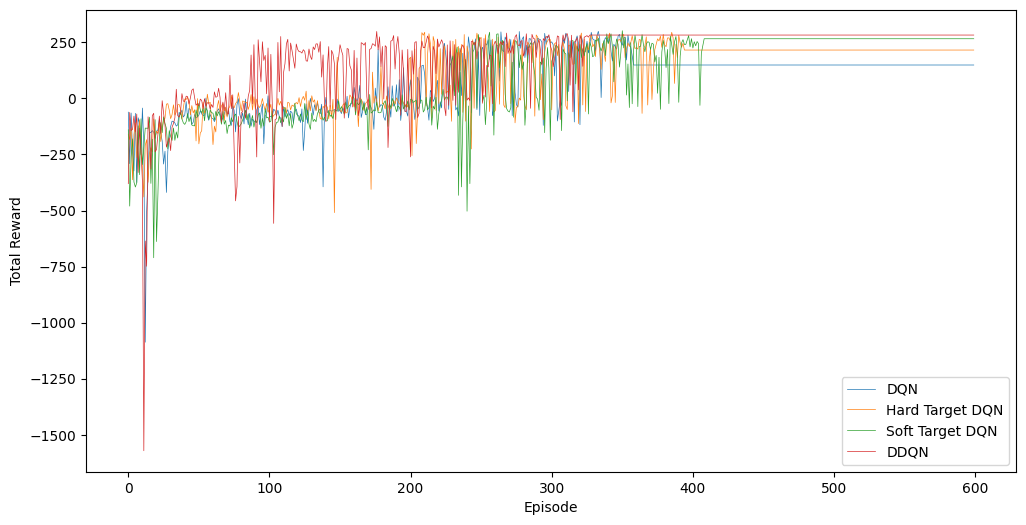

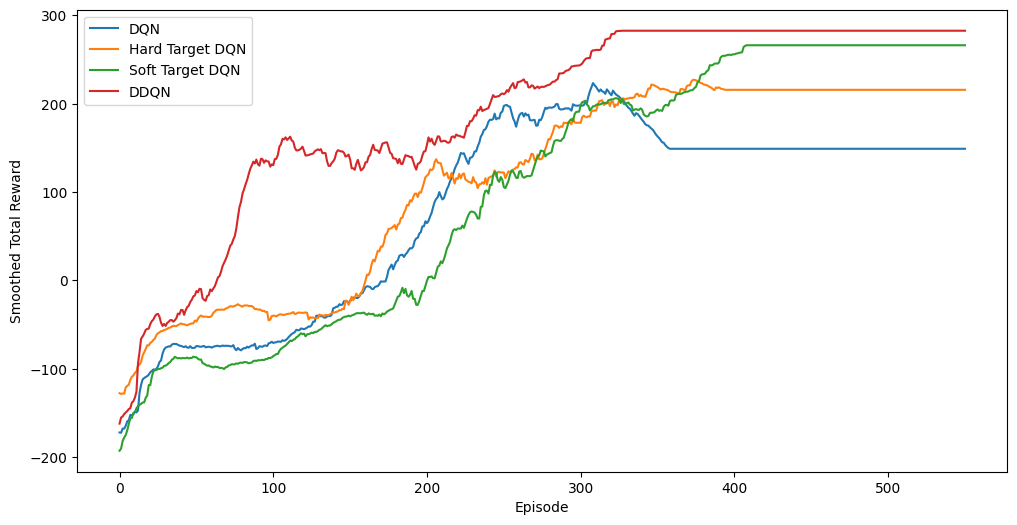

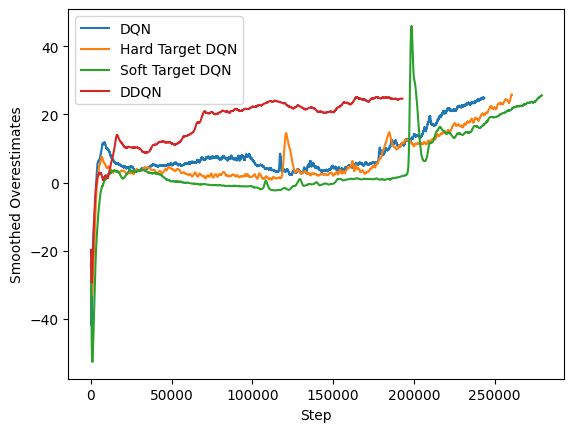

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(dqn_rewards, label='DQN', linewidth=0.5)
plt.plot(hard_dqn_rewards, label='Hard Target DQN', linewidth=0.5)
plt.plot(soft_dqn_rewards, label='Soft Target DQN', linewidth=0.5)
plt.plot(ddqn_rewards, label='DDQN', linewidth=0.5)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.show()

window_size = 50

plt.figure(figsize=(12, 6))

smoothed_dqn_rewards = np.convolve(dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_hard_dqn_rewards = np.convolve(hard_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_soft_dqn_rewards = np.convolve(soft_dqn_rewards, np.ones(window_size)/window_size, mode='valid')
smoothed_ddqn_rewards = np.convolve(ddqn_rewards, np.ones(window_size)/window_size, mode='valid')

plt.plot(smoothed_dqn_rewards, label='DQN', linewidth=1.5)
plt.plot(smoothed_hard_dqn_rewards, label='Hard Target DQN', linewidth=1.5)
plt.plot(smoothed_soft_dqn_rewards, label='Soft Target DQN', linewidth=1.5)
plt.plot(smoothed_ddqn_rewards, label='DDQN', linewidth=1.5)

plt.xlabel('Episode')
plt.ylabel('Smoothed Total Reward')
plt.legend()
plt.show()

smoothed_dqn_overesimates = np.convolve(dqn_agent.overestimation_tracker, np.ones(1000)/1000, mode='valid')
smoothed_hard_dqn_overesimates = np.convolve(hard_dqn_agent.overestimation_tracker, np.ones(1000)/1000, mode='valid')
smoothed_soft_dqn_overesimates = np.convolve(soft_dqn_agent.overestimation_tracker, np.ones(1000)/1000, mode='valid')
smoothed_ddqn_overesimates = np.convolve(ddqn_agent.overestimation_tracker, np.ones(1000)/1000, mode='valid')

plt.plot(smoothed_dqn_overesimates, label='DQN', linewidth=1.5)
plt.plot(smoothed_hard_dqn_overesimates, label='Hard Target DQN', linewidth=1.5)
plt.plot(smoothed_soft_dqn_overesimates, label='Soft Target DQN', linewidth=1.5)
plt.plot(smoothed_ddqn_overesimates, label='DDQN', linewidth=1.5)

plt.xlabel('Step')
plt.ylabel('Smoothed Overestimates')
plt.legend()
plt.show()

# Analysis and Conclusion

Hard Target DQN underperforms with regards to other strategies on this particular ennvironment due to the fact, that we are "smoothing out" the learning process of the agent.

Any method with regularization has it drawbacks and usually increases convergence time in return for greater training stibility. 

DQN and Soft Target DQN are on par within this particular environment, because they're close by nature and there is little to no instability between alike state-actions pairs. Also it indicates that tau hyperparameter was chosen just right.

DDQN, as expected, outperforms all above.

Rules of thumb:
* Use DDQN when significant overestimation of Q-values is observed with classic DQN, which might lead to suboptimal policy learning.
* Use soft target updates when smoother and potentially more stable training is needed, especially in environments where small policy changes are preferable.
* Use hard target updates in scenarios where computational simplicity is preferred, and the environment doesn't suffer significantly from the potential instability caused by abrupt updates.
* Experiment :)